<a href="https://colab.research.google.com/github/Fahim17/Kaggle_Competitions/blob/master/Predict_the_Diabetes!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c predict-the-diabetes

  0% 0.00/10.7k [00:00<?, ?B/s]
100% 10.7k/10.7k [00:00<00:00, 10.4MB/s]
  0% 0.00/2.04k [00:00<?, ?B/s]
100% 2.04k/2.04k [00:00<00:00, 2.16MB/s]
  0% 0.00/17.7k [00:00<?, ?B/s]
100% 17.7k/17.7k [00:00<00:00, 18.0MB/s]


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchvision import transforms

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
data = pd.read_csv('train.csv')
train_col = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
train_x = data[train_col]
train_y = data['Outcome']

# min_max_scaler = preprocessing.MinMaxScaler()


col_x = data["Pregnancies"].values.astype(float)
col_std = np.std(col_x)
col_mean = np.mean(col_x)
col_x_scaled = (col_x-col_mean)/col_std
# col_x_scaled = min_max_scaler.fit_transform(col_x)
train_x["Pregnancies"] = col_x_scaled
train_x

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.580194,148,72,35,0,33.6,0.627,50
1,1.169878,183,64,0,0,23.3,0.672,32
2,-0.894017,89,66,23,94,28.1,0.167,21
3,1.759562,115,0,0,0,35.3,0.134,29
4,-0.599175,197,70,45,543,30.5,0.158,53
...,...,...,...,...,...,...,...,...
461,-0.599175,88,58,26,16,28.4,0.766,22
462,1.464720,170,74,31,0,44.0,0.403,43
463,1.464720,89,62,0,0,22.5,0.142,33
464,1.759562,101,76,48,180,32.9,0.171,63


                          Pregnancies   Glucose  ...   Outcome        Id
Pregnancies                  1.000000  0.144798  ...  0.245790 -0.036067
Glucose                      0.144798  1.000000  ...  0.462225  0.000631
BloodPressure                0.185053  0.101713  ...  0.026824  0.029407
SkinThickness               -0.108061  0.042815  ...  0.055047 -0.001977
Insulin                     -0.074614  0.326777  ...  0.114341  0.023472
BMI                          0.013181  0.208530  ...  0.284855  0.019808
DiabetesPedigreeFunction    -0.059920  0.175660  ...  0.184296 -0.026599
Age                          0.577494  0.271597  ...  0.250254  0.007302
Outcome                      0.245790  0.462225  ...  1.000000 -0.049880
Id                          -0.036067  0.000631  ... -0.049880  1.000000

[10 rows x 10 columns]


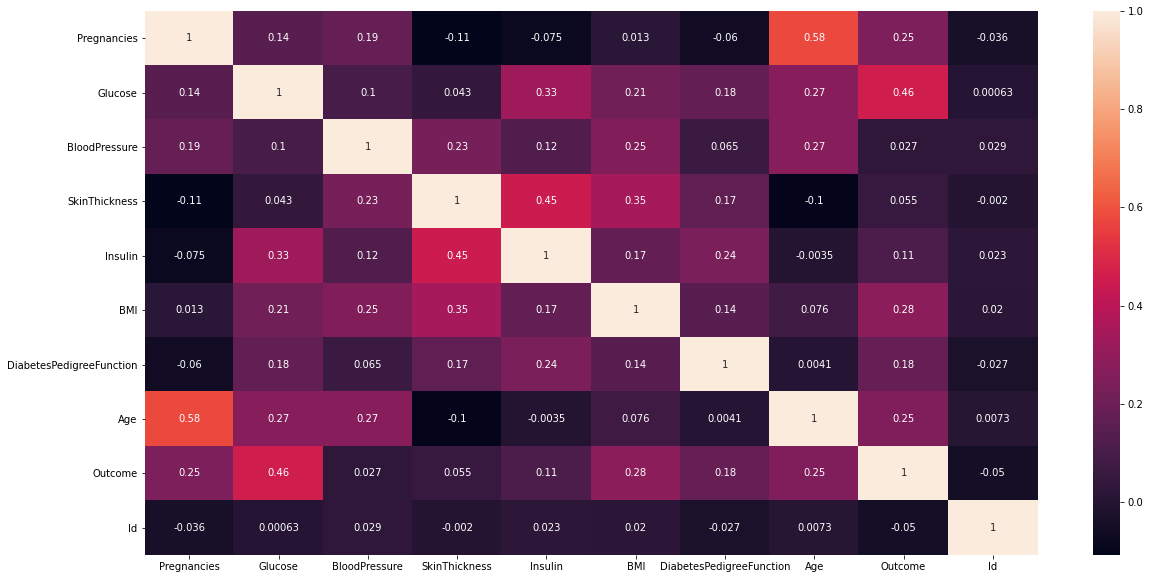

In [4]:
# for col in train_col:
#   # if col =='Age': 
#   #   continue
#   print(f'processing column {col}')
#   col_x = data[col].values.astype(float)
#   col_std = np.std(col_x)
#   col_mean = np.mean(col_x)
#   col_x_scaled = (col_x-col_mean)/col_std
#   data[col] = col_x_scaled

corr = data.corr()
print(corr)

import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sn.heatmap(corr, annot=True)
plt.show()

In [5]:
class diabetes_dataset(Dataset):
  def __init__(self, train_csv = None, istest = False):
    self.csv_file = pd.read_csv(train_csv)
    self.train_col = ['Pregnancies','Glucose','Insulin','BMI','DiabetesPedigreeFunction','Age']
    # self.train_col = ['Glucose', 'Age']
    self.istest = istest

    for col in self.train_col:
      # if col =='Age': 
      #   continue
      print(f'processing column {col}')
      col_x = self.csv_file[col].values.astype(float)
      col_std = np.std(col_x)
      col_mean = np.mean(col_x)
      col_x_scaled = (col_x-col_mean)/col_std
      self.csv_file[col] = col_x_scaled
    print(self.csv_file.head())
 

  def __len__(self):
    return self.csv_file.shape[0]

  def __getitem__(self, idx):
    X = self.csv_file[self.train_col].iloc[idx]
    X = torch.tensor(X).float()

    if (not self.istest):
      y = self.csv_file['Outcome'].iloc[idx]
      y = torch.tensor(y).float()

    if (not self.istest):
      return X, y
    elif(self.istest):
      return X
    else:
      return 'wrong wrong wrong'



In [6]:
dst1 = diabetes_dataset('train.csv', istest = False)
data_loader = DataLoader(dst1, batch_size = 30, shuffle=True)



processing column Pregnancies
processing column Glucose
processing column Insulin
processing column BMI
processing column DiabetesPedigreeFunction
processing column Age
   Pregnancies   Glucose  BloodPressure  ...       Age  Outcome  Id
0     0.580194  0.797697             72  ...  1.468113        1   0
1     1.169878  1.875522             64  ... -0.105428        1   2
2    -0.894017 -1.019209             66  ... -1.067036        0   3
3     1.759562 -0.218539              0  ... -0.367685        0   7
4    -0.599175  2.306652             70  ...  1.730370        1   8

[5 rows x 10 columns]


In [7]:
class fullConnectNN(nn.Module):
  def __init__(self, num_input):
    super(fullConnectNN,self).__init__()
    
    self.fc1 = nn.Linear(num_input, 1)
    # self.fc2 = nn.Linear(128, 64)
    # self.fc3 = nn.Linear(64, 1)
    # self.dropout = nn.Dropout(p=0.3)


  def forward(self, x):
    # x = self.dropout(F.relu(self.fc1(x)))
    # x = self.dropout(F.relu(self.fc2(x)))
    x = F.sigmoid(self.fc1(x))

    return x

In [15]:
model = fullConnectNN(num_input=6)
print(model)

fullConnectNN(
  (fc1): Linear(in_features=6, out_features=1, bias=True)
)


In [20]:
import torch.optim as optim

# criterion = nn.BCELoss()
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [22]:
for epoch in range(10):  # loop over the dataset multiple times
    print(f'Running epoch {epoch}')
    running_loss = 0.0
    batch_no =0
    for data, label in data_loader:
       
        optimizer.zero_grad()
        
        outputs = model(data)
        # print(outputs)    
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        batch_no+=1
        
        # if batch_no%2 ==0:
        #     # print(f'Running epoch {epoch}, batch no {batch_no}')
        #     print(f'total loss after {batch_no} batches ---- Loss: {running_loss}')
            # running_loss = 0

    print(f'Loss: {running_loss}')
            


Running epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 3.763739228248596
Running epoch 1
Loss: 3.787232995033264
Running epoch 2
Loss: 3.785004287958145
Running epoch 3
Loss: 3.837301552295685
Running epoch 4
Loss: 3.776236891746521
Running epoch 5
Loss: 3.819910705089569
Running epoch 6
Loss: 3.796562060713768
Running epoch 7
Loss: 3.753693699836731
Running epoch 8
Loss: 3.7786422967910767
Running epoch 9
Loss: 3.7853976488113403


In [18]:
dst_test = diabetes_dataset('test.csv', istest = True)
sub = pd.read_csv('sample_submission.csv')

for i in range(dst_test.__len__()):
  sub.Outcome.iloc[i] = float(model(dst_test[i]))
sub.to_csv('result.csv', index=False)


processing column Pregnancies
processing column Glucose
processing column Insulin
processing column BMI
processing column DiabetesPedigreeFunction
processing column Age
   Pregnancies   Glucose  BloodPressure  ...  DiabetesPedigreeFunction       Age  Id
0    -0.772550 -1.096656             66  ...                 -0.340413 -0.187779   1
1    -1.074766  0.578625             40  ...                  5.275452 -0.024116   4
2     0.436311 -0.097931             74  ...                 -0.775302 -0.269611   5
3    -0.168120 -1.322174             50  ...                 -0.639037 -0.596937   6
4     1.342957  0.192021             96  ...                 -0.685425  1.694348   9

[5 rows x 9 columns]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
sub

,Id,Outcome
0,1,0.481812
1,4,0.503168
2,5,0.459190
3,6,0.446223
4,9,0.559588
...,...,...
297,758,0.439598
298,759,0.500377
299,764,0.443099
300,765,0.458471
